In [1]:
import jax, numpyro
import jax.numpy as jnp
from jax import config
config.update('jax_platform_name', 'cpu')
config.update('jax_enable_x64', True)
numpyro.set_platform('cpu')

In [2]:
import numpy as np
import pandas as pd
from jax import random
from jaxspec.specfit import SpecFit
from jaxspec.infer import *
from jaxspec.numpyro_model import model_single as model
import glob, pathlib, dill, corner

In [3]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10,4)
plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.facecolor'] = 'white'

## load sample data
- This part should be changed according to the data you have
- We need: wav_obs, flux_obs, error_obs, mask_obs; all have the same shapes of (number of orders) x (number of pixels in each order)
- mask_obs: if True the data point is masked

In [4]:
def load_ird_spectrum(datapath, orders):
    orders = np.atleast_1d(orders)
    data = pd.read_csv(datapath)
    wav_obs = np.array(data.lam).reshape(-1,2048)[orders,:] * 10 # nm -> AA
    flux_obs = np.array(data.normed_flux).reshape(-1,2048)[orders,:]
    error_obs = np.array(data.flux_error).reshape(-1,2048)[orders,:]
    mask_obs = np.array(data.all_mask).reshape(-1,2048)[orders,:]
    return [wav_obs, flux_obs, error_obs, mask_obs]

In [5]:
datapath = "../data/IRDA00042313_H.csv"
orders = [8,9]

In [6]:
wav_obs, flux_obs, error_obs, mask_obs = load_ird_spectrum(datapath, orders)

In [7]:
# (number of orders) x (number of pixels in each order)
print (np.shape(wav_obs))

(2, 2048)


<>:4: SyntaxWarning: invalid escape sequence '\m'
<>:4: SyntaxWarning: invalid escape sequence '\m'
/var/folders/qp/91qlh0v11sb02z6vb4nb_s0m0000gn/T/ipykernel_55620/3536304845.py:4: SyntaxWarning: invalid escape sequence '\m'
  plt.xlabel("wavelength ($\mathrm{\AA}$)")


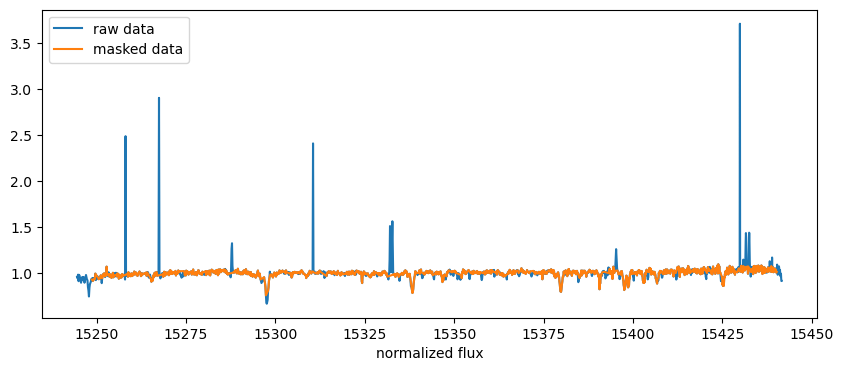

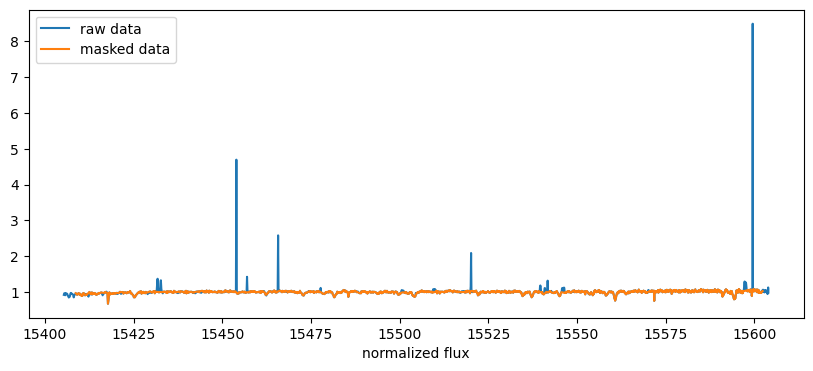

In [8]:
for j in range(len(orders)):
    clip = ~mask_obs[j]
    plt.figure()
    plt.xlabel("wavelength ($\mathrm{\AA}$)")
    plt.xlabel("normalized flux")
    plt.plot(wav_obs[j], flux_obs[j], label='raw data')
    plt.plot(wav_obs[j][clip], flux_obs[j][clip], label='masked data')
    plt.legend(loc='best');

## path to the spectrum grid 
- here we use the output of compute_coelho_grid.py

In [9]:
gridpath = "/Users/k_masuda/data/specgrid_irdh_coelho"

## specfit class

In [10]:
sf = SpecFit(gridpath, [wav_obs, flux_obs, error_obs, mask_obs], orders, vmax=50., wav_margin=3.)

In [11]:
# set fixed wavelength resolution
wavres = np.array([70000]*len(orders))
sf.add_wavresinfo(wavres, wavres)

## check cross correlation function

# order 8
# order 9


(-23.588105813398162, 17.301730173017305)

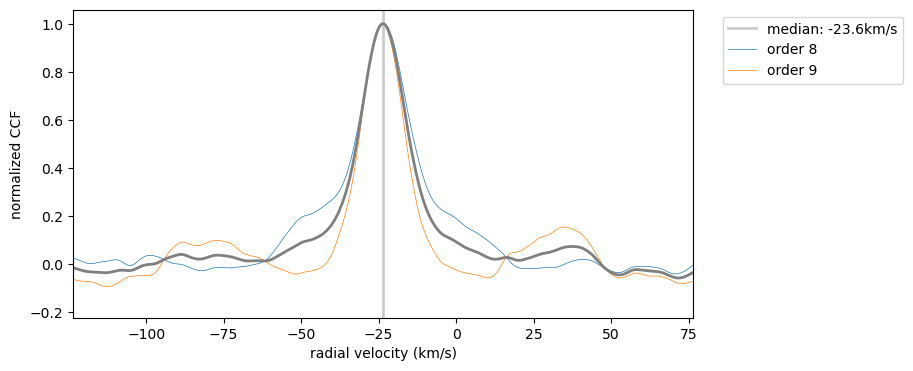

In [12]:
sf.check_ccf()

## optimization

In [13]:
param_bounds = get_parameter_bounds(sf)

In [14]:
p_fit = optim_svi(model, 1e-2, 5000, sf=sf, param_bounds=param_bounds) 

100%|██████████| 5000/5000 [01:14<00:00, 66.81it/s, init loss: -2035.8749, avg. loss [4751-5000]: -8292.8361]


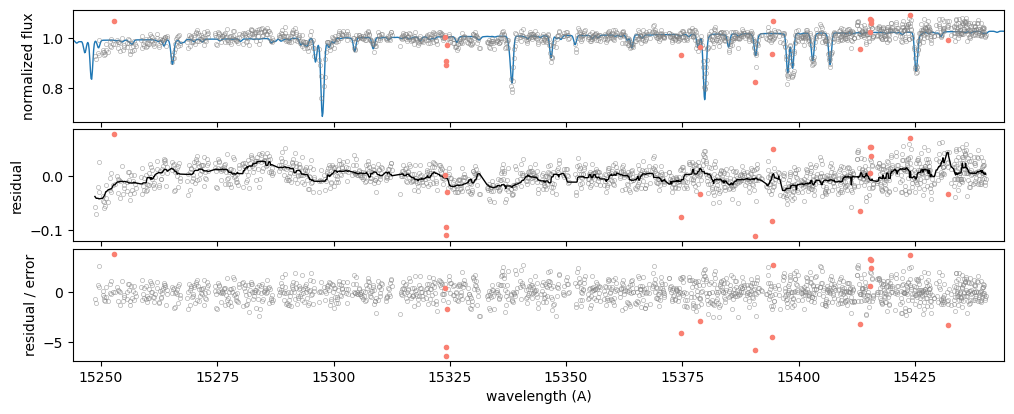

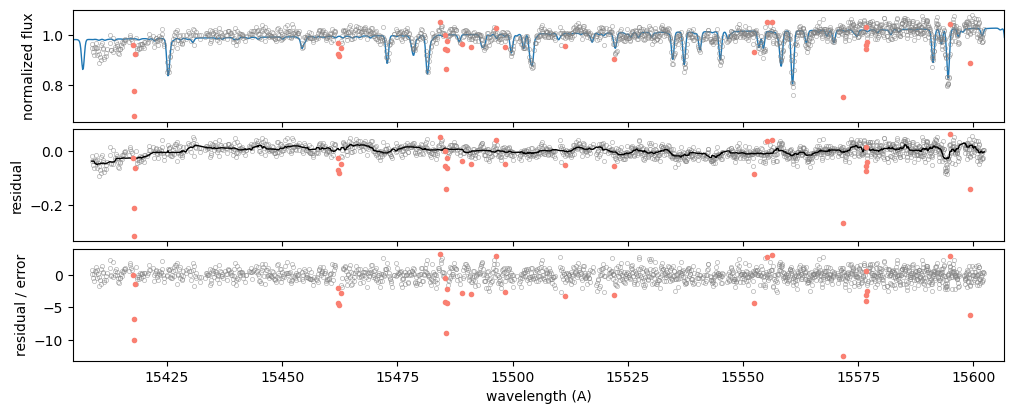

In [15]:
# mask outliers
sf.mask_outliers(p_fit, plot=True, sigma_threshold=3.)

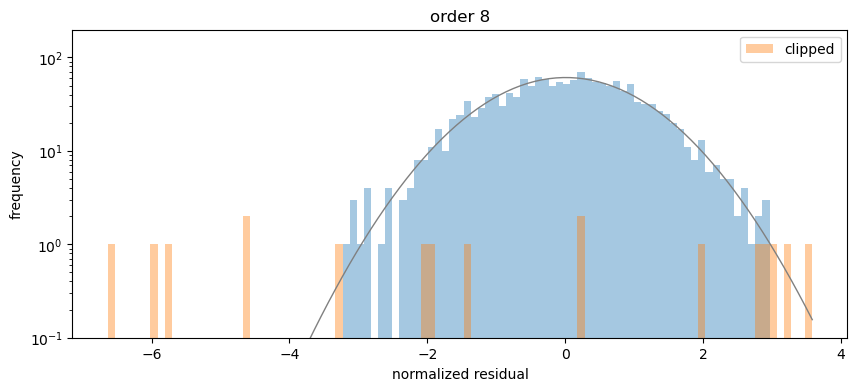

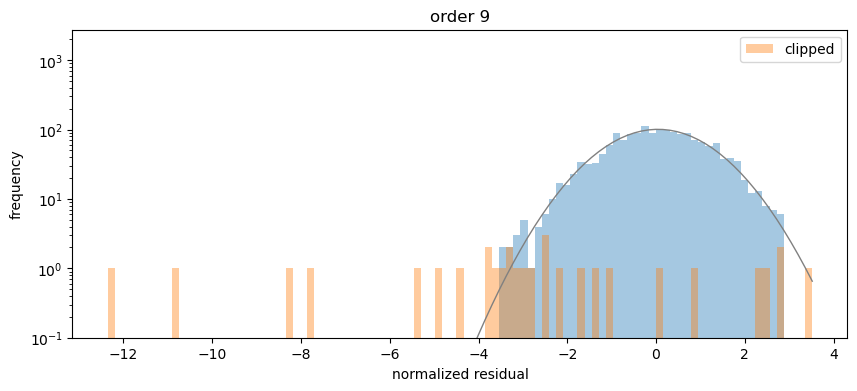

In [16]:
sf.check_residuals(p_fit)

In [17]:
# optimize again
p_fit = optim_svi(model, 1e-2, 2000, sf=sf, param_bounds=param_bounds, p_initial=p_fit) 

100%|██████████| 2000/2000 [00:35<00:00, 55.93it/s, init loss: -8477.5786, avg. loss [1901-2000]: -8503.3416]


## posterior sampling

In [22]:
p_scaled = scale_pdic(p_fit, param_bounds, keys_to_keep=['lna', 'lnc', 'lnsigma'])

In [23]:
p_scaled

{'teff_scaled': Array(0.64133196, dtype=float64),
 'logg_scaled': Array(0.43993711, dtype=float64),
 'alpha_scaled': Array(0.04495102, dtype=float64),
 'vsini_scaled': Array(0.43073119, dtype=float64),
 'zeta_scaled': Array(0.63960556, dtype=float64),
 'q1_scaled': Array(0.44249982, dtype=float64),
 'q2_scaled': Array(0.45688734, dtype=float64),
 'norm_scaled': Array([0.53320663, 0.52708426], dtype=float64),
 'slope_scaled': Array([0.59919049, 0.61438755], dtype=float64),
 'rv_scaled': Array([0.54566806, 0.50595111], dtype=float64),
 'feh_scaled': Array(0.6666233, dtype=float64),
 'lna': Array(-4.47123128, dtype=float64),
 'lnc': Array(0.30766921, dtype=float64),
 'lnsigma': Array(-7.95665836, dtype=float64)}

In [ ]:
from numpyro.infer import init_to_value
kernel = numpyro.infer.NUTS(model, target_accept_prob=0.90, init_strategy=init_to_value(values=p_scaled), dense_mass=True)
mcmc = numpyro.infer.MCMC(kernel, num_warmup=500, num_samples=500)

In [25]:
print ("# running HMC...")
rng_key = random.PRNGKey(0)
mcmc.run(rng_key, sf, param_bounds, physical_logg_max=True, empirical_vmacro=False)
mcmc.print_summary()
smp = mcmc.get_samples()

# running HMC...


  0%|          | 0/1000 [00:00<?, ?it/s]2024-11-22 20:48:30.378482: E external/xla/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit__body_fn] Slow compile? XLA was built without compiler optimizations, which can be slow. Try rebuilding with -c opt.
********************************
2024-11-22 20:48:31.964229: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 11.590688s

********************************
[Compiling module jit__body_fn] Slow compile? XLA was built without compiler optimizations, which can be slow. Try rebuilding with -c opt.
********************************
sample: 100%|██████████| 1000/1000 [08:37<00:00,  1.93it/s, 31 steps of size 1.28e-01. acc. prob=0.94]  



                     mean       std    median      5.0%     95.0%     n_eff     r_hat
   alpha_scaled      0.05      0.04      0.03      0.00      0.10    648.36      1.00
     feh_scaled      0.78      0.02      0.78      0.74      0.82    183.84      1.00
            lna     -4.47      0.07     -4.47     -4.57     -4.34    642.84      1.00
            lnc      0.51      0.19      0.50      0.20      0.80    519.80      1.00
        lnsigma     -8.53      0.85     -8.60     -9.83     -7.20    573.93      1.00
           logg      4.31      0.17      4.33      4.11      4.58    131.52      1.00
 norm_scaled[0]      0.53      0.00      0.53      0.53      0.54    539.02      1.00
 norm_scaled[1]      0.53      0.00      0.53      0.52      0.54    597.49      1.00
      q1_scaled      0.51      0.28      0.52      0.05      0.93    567.27      1.00
      q2_scaled      0.48      0.28      0.50      0.04      0.89    471.64      1.00
   rv_scaled[0]      0.55      0.01      0.55      0.

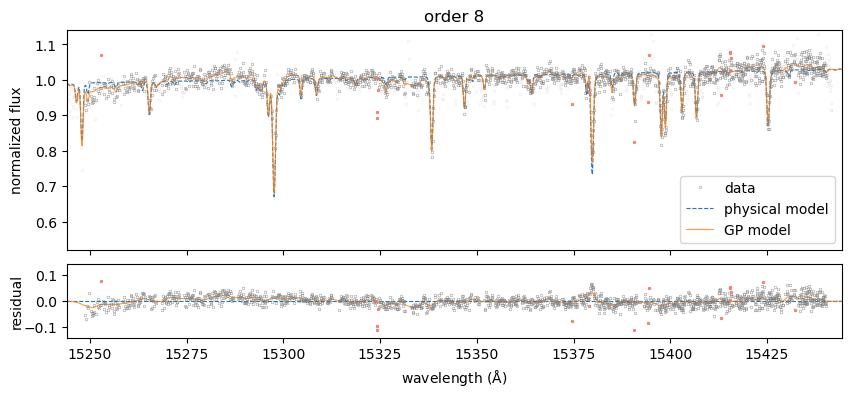

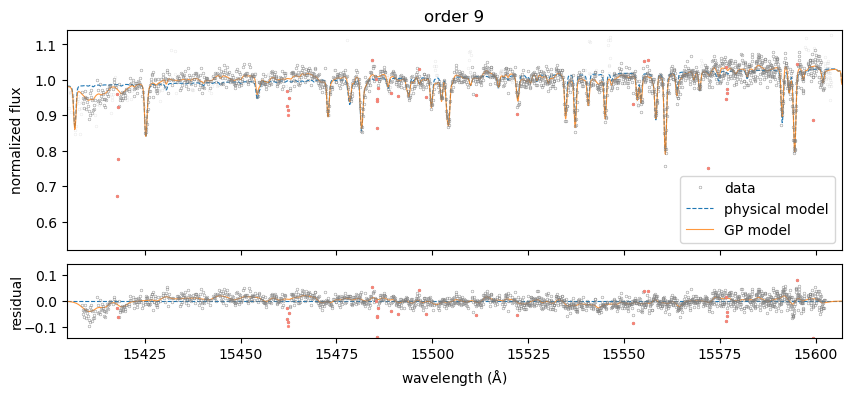

In [26]:
ms, mgps = get_mean_models(smp, sf)
sf.plot_models(ms, mgps=mgps)

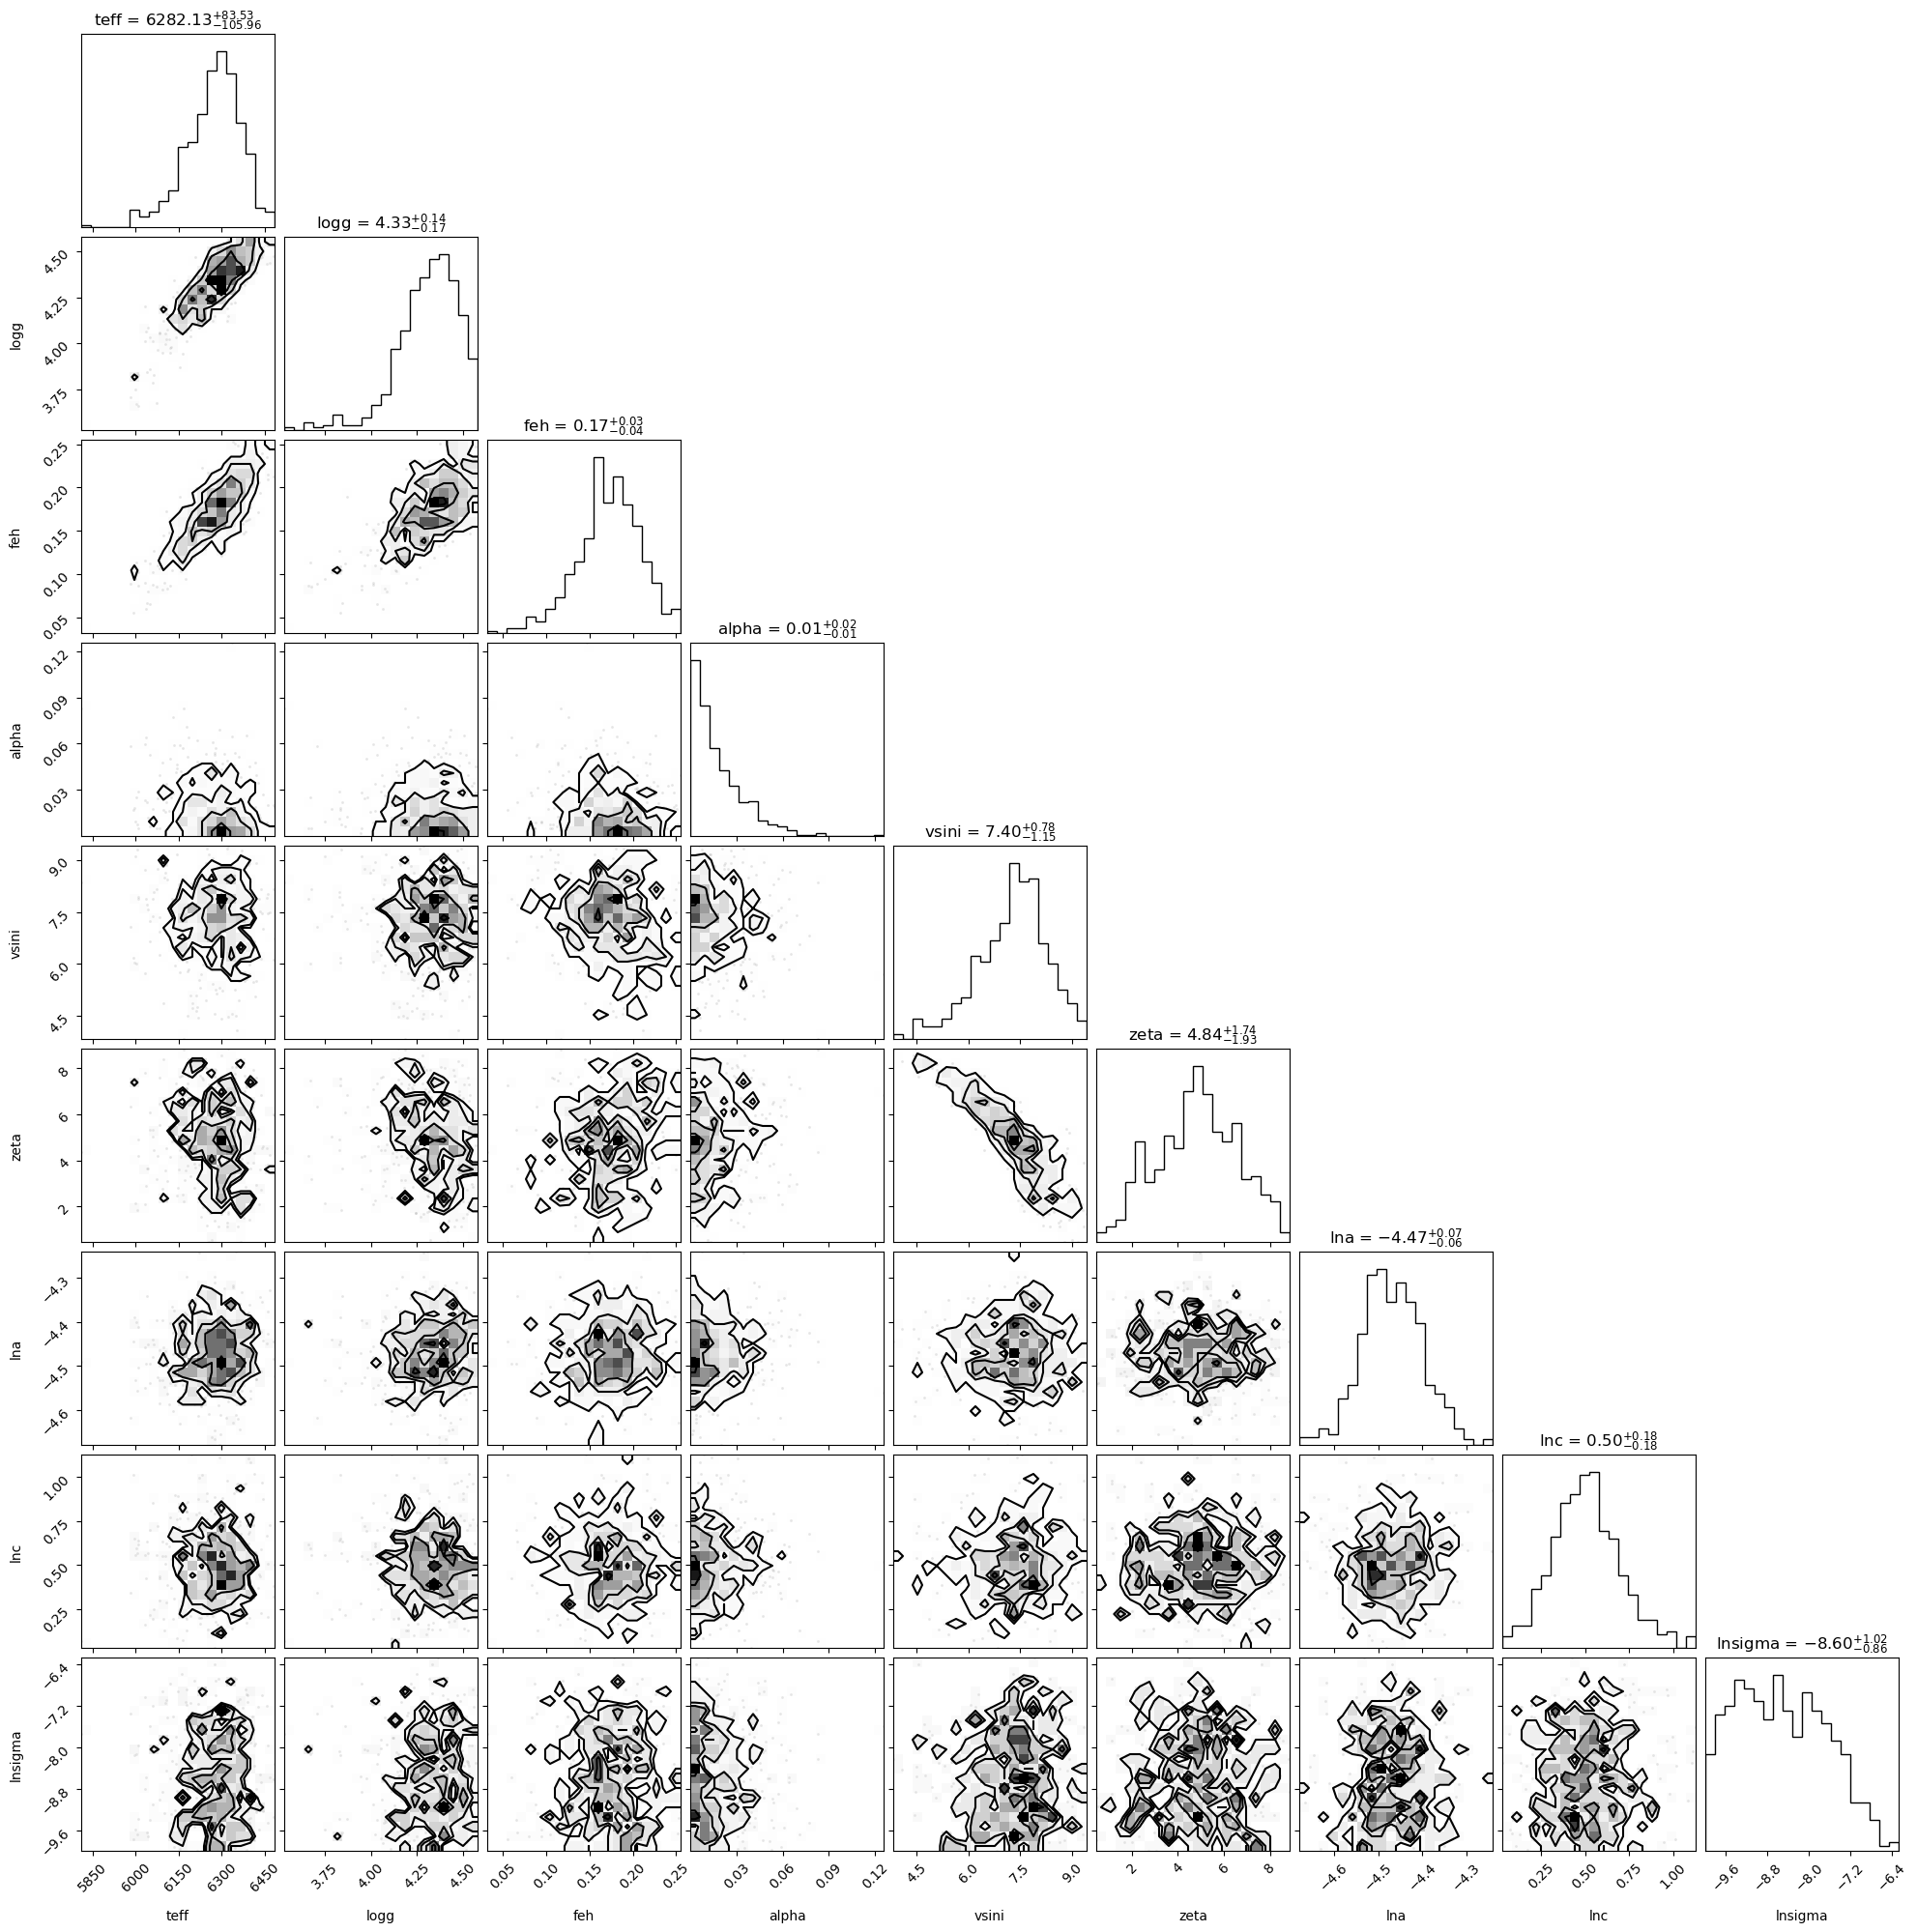

In [27]:
names = ['teff', 'logg', 'feh', 'alpha', 'vsini', 'zeta', 'lna', 'lnc', 'lnsigma']
hyper = np.array(pd.DataFrame(data=dict(zip(names, [smp[k] for k in names]))))
fig = corner.corner(hyper, labels=names, show_titles="%.2f")